In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import get_mesh_vtk
from utils import get_data
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
from KPCA import *
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
# import torch.nn as nn
from utils import calc_energy

# from importlib import reload

In [83]:
vtk_file = '../npz_data/Dados-N0.vtk'
x, y = get_mesh_vtk(vtk_file)

dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
xc = (x[1:] + x[:-1])/2
yc = (y[1:] + y[:-1])/2
X, Y = np.meshgrid(xc,yc)
DX, DY = np.meshgrid(dx,dy)
AREA = DX*DY
print(DX.shape)

(181, 181)


In [84]:
in_filename = f'../npz_data/new_cross_data_Re0.01_Wi5_beta0.11111.npz'
# in_filename = f'../npz_data/cross_data_Re{Re:g}_Wi{Wi:g}_beta{beta:g}.npz'
# in_filename = f'../npz_data/4_roll6_Re{Re:g}_Wi{Wi:g}_beta{beta:g}_dataset.npz'

eps_u = 1

fields = np.load(in_filename, allow_pickle=True)["fields"].item()
u = fields["vel-u"] * eps_u
v = fields["vel-v"] * eps_u
Bxx = fields["Bxx"]
Bxy = fields["Bxy"]
Byy = fields["Byy"]
q = np.stack((u,v,Bxx, Bxy, Byy), axis=-1)

q[:65,:65] = np.nan
q[:65,-65:] = np.nan
q[-65:,:65] = np.nan
q[-65:,-65:] = np.nan

In [85]:
tra = q[...,2] + q[...,4]

In [86]:
(tra[...,50]*AREA)[0,0], tra[...,50][0,0], q[...,50,2][0,0]

(nan, nan, nan)

(10.01, 10.9903895, 10.01, 10.9903895)

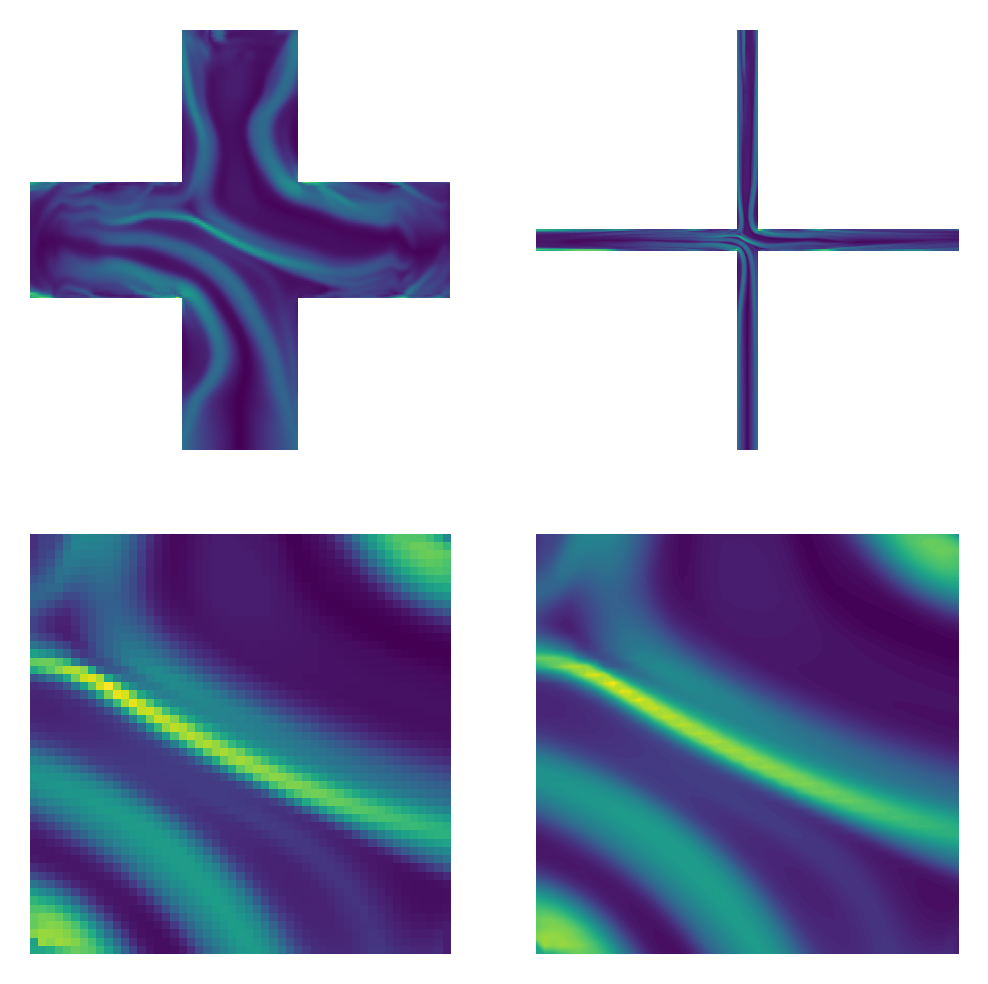

In [20]:
t = 100 
lvs = 100
fig =plt.figure(figsize=(4,4),dpi=300,facecolor='w')
ax1 = plt.subplot(221)
ax1.imshow(tra[...,t], origin='lower')
ax1.axis('off')
ax1 = plt.subplot(222)
ax1.contourf(X,Y, tra[...,t], levels = lvs)
ax1.axis('off')
ax1 = plt.subplot(223)
ax1.imshow(tra[...,t][65:-65,65:-65], origin='lower')
ax1.axis('off')
ax1 = plt.subplot(224)
ax1.contourf(X[65:-65,65:-65],Y[65:-65,65:-65], tra[...,t][65:-65,65:-65], levels = lvs)
ax1.axis('off')

In [35]:
np.nanmin((tra[...,t])),np.nanmax((tra[...,t]))

(2.0747995, 99.53734)

In [81]:
np.nanargmax(tra[...,t]/AREA),(tra[...,t]/AREA).item(67*181+50)

(20932, 21396.23801248391)

In [97]:
X[range(181),vmax].shape

(181,)

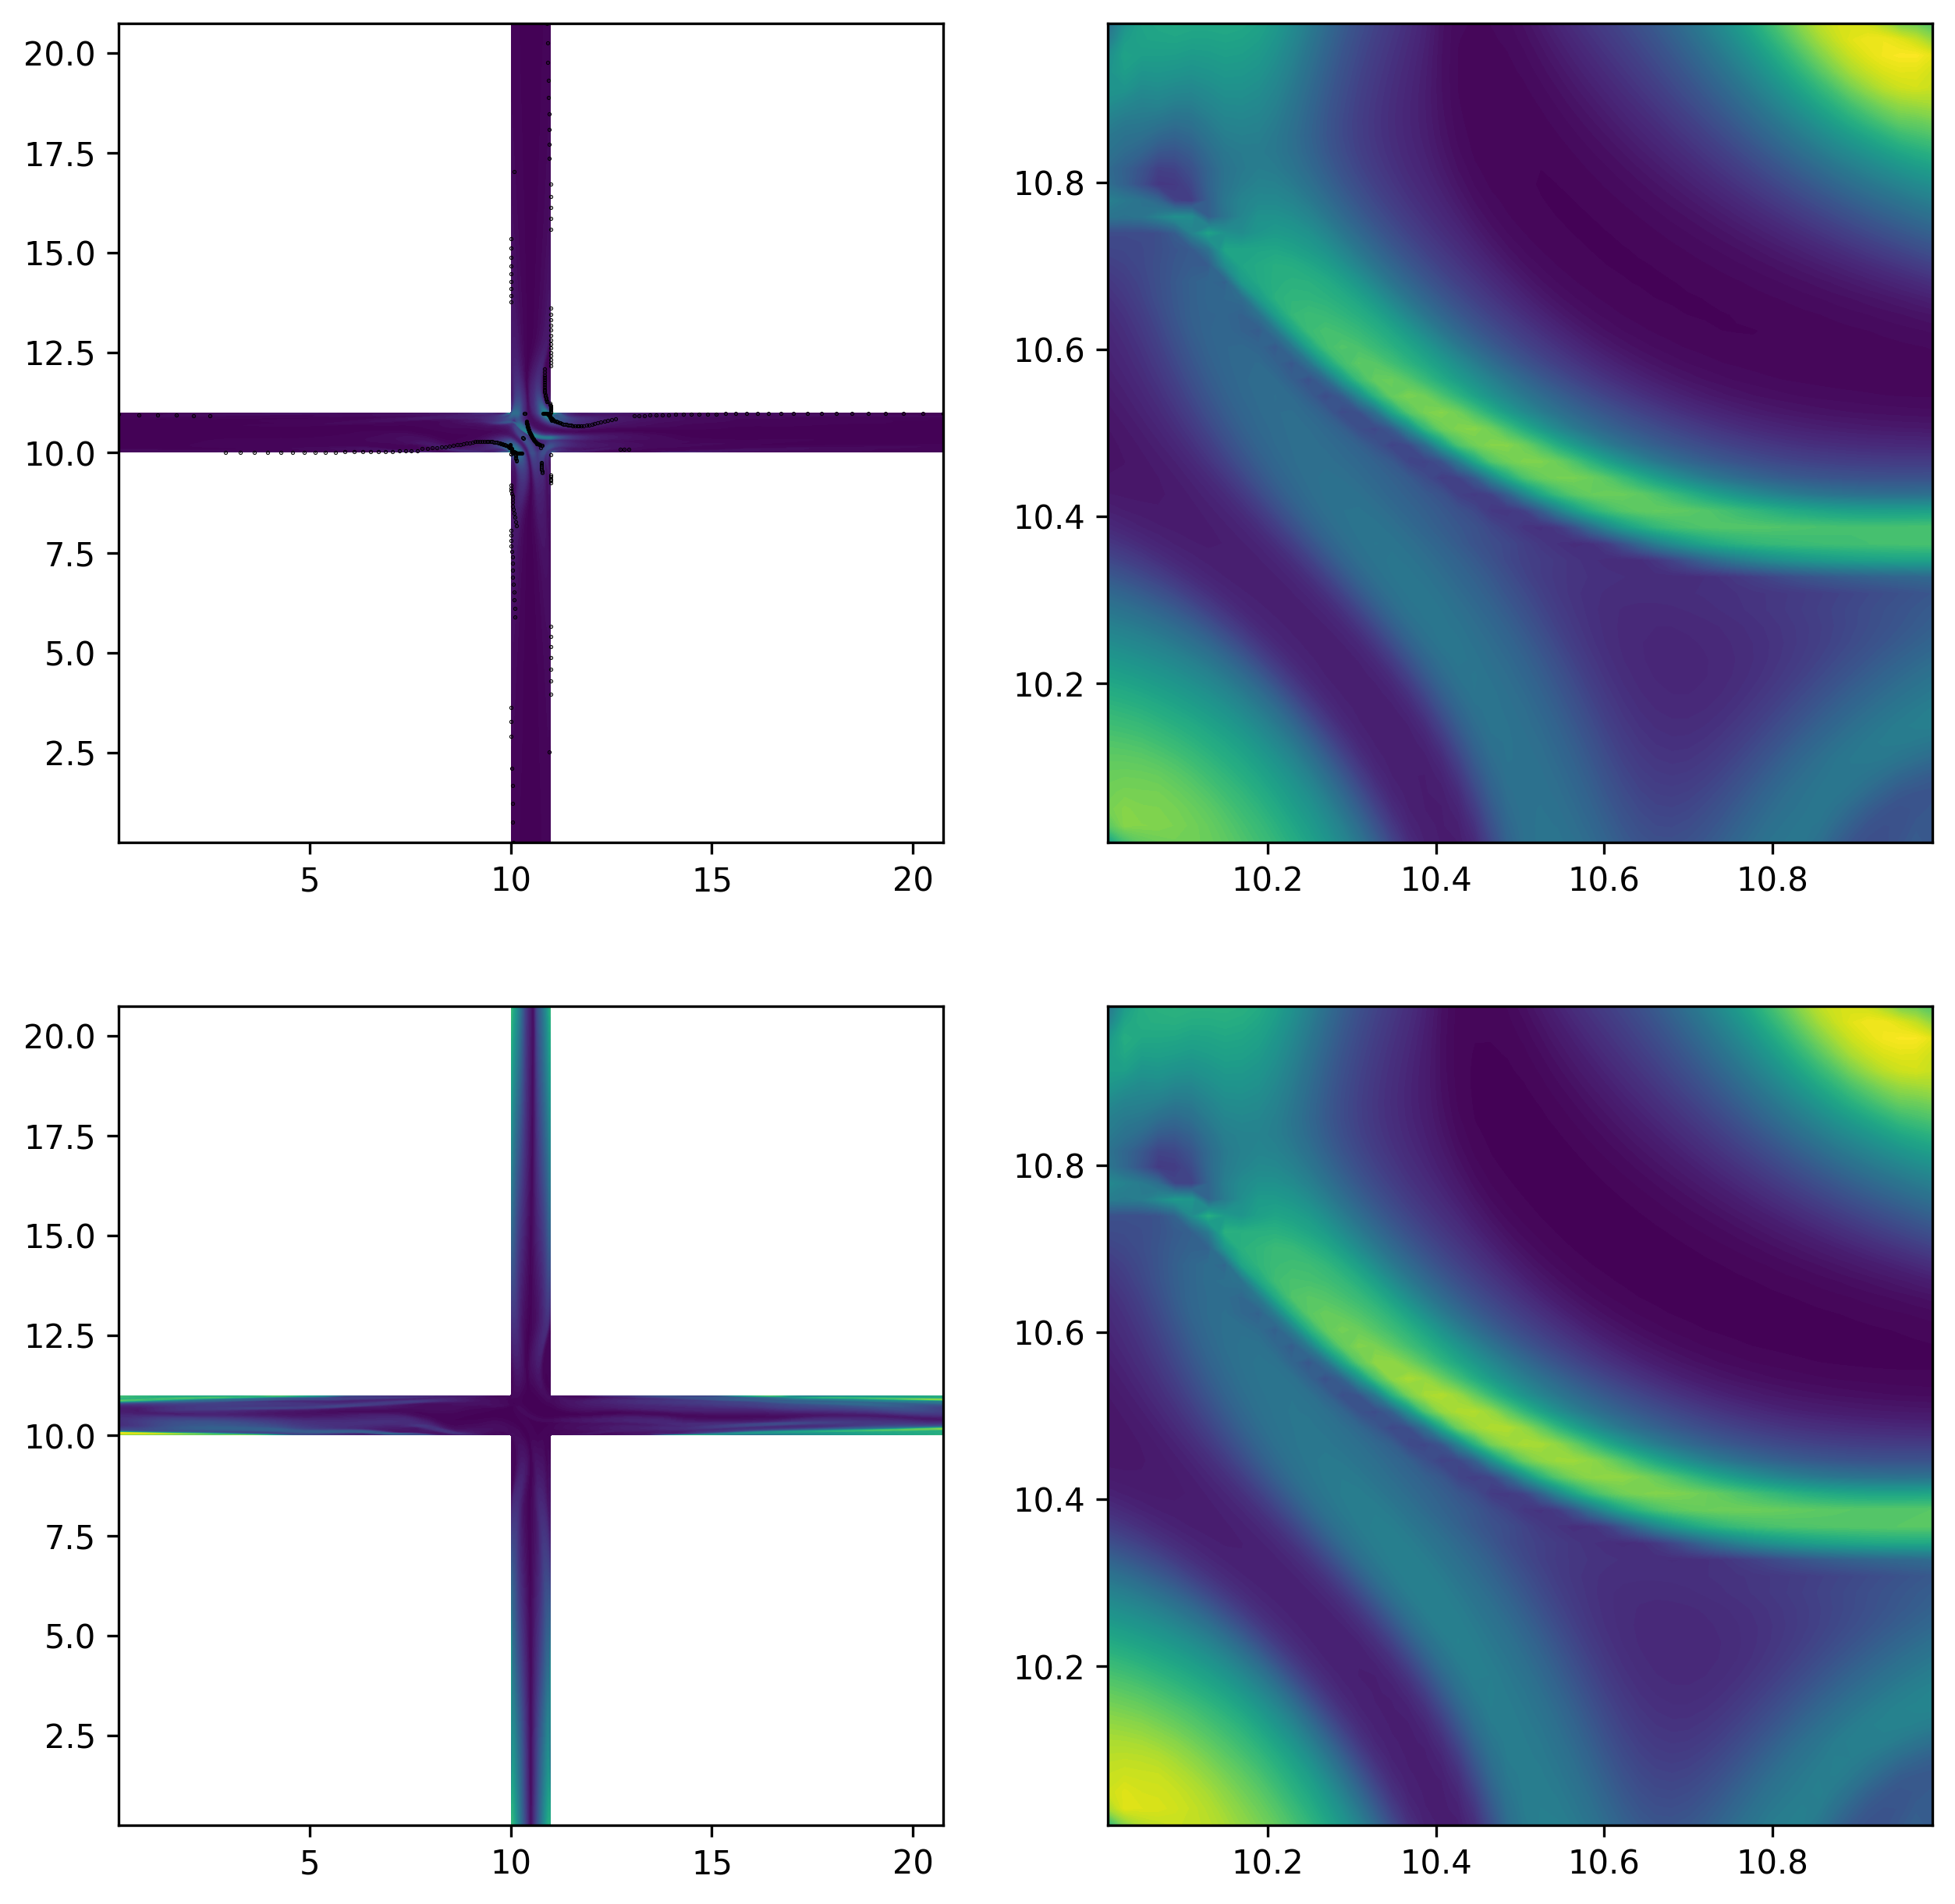

In [105]:
t = 50
fig =plt.figure(figsize=(10,10),dpi=300,facecolor='w')

ax1 = plt.subplot(221)
ax = plt.contourf(X,Y,(tra[...,t]/AREA), levels = 100)
xmax = np.nanargmax(tra[...,t]/AREA, axis = 0)
ymax = np.nanargmax(tra[...,t]/AREA, axis = 1)
# plt.plot(X.item(vmax), Y.item(vmax), 'r.')
plt.plot(X[range(181),xmax], Y[range(181),xmax], 'k.', markersize = .5)
plt.plot(X[ymax,range(181)], Y[ymax,range(181)], 'k.', markersize = .5)
# plt.colorbar()
# plt.colorbar()

ax1 = plt.subplot(222)
plt.contourf(X[65:-65,65:-65],Y[65:-65,65:-65],(tra[...,t]/AREA)[65:-65,65:-65], levels = 100)
# plt.colorbar()

ax1 = plt.subplot(223)
ax = plt.contourf(X,Y,(tra[...,t]*AREA), levels = 100)


ax1 = plt.subplot(224)
plt.contourf(X[65:-65,65:-65],Y[65:-65,65:-65],(tra[...,t]*AREA)[65:-65,65:-65], levels = 100)
# plt.colorbar()


In [17]:
encoder  = Autoencoder.Encoder(4)
decoder  = Autoencoder.Decoder(4)

autoencoder = nn.Sequential(encoder, decoder)

In [64]:
def get_reconst(Re,Wi,beta,eps, X, modes_list, kernel, loss_kernel, norm):

    E_mmq = []
    F_mmq = []
    E_energy = []
    degree = 1
    alpha = (1-beta)/(Re*Wi)
    _, _, total_X = calc_energy(X, Wi, beta, Re, dx = 0.0125)
    # target_X = (X-Xmean).T
    target_X = X.T
    
    max_m = np.max(modes_list)
    # _, Q, _, _ = kpca(X.T, n_components=max_m, kernel=kernel, gamma=alpha, norm=norm, eps = eps)# Old
    Q, _, _, _ = kpca(X.T, n_components=max_m, kernel=kernel, gamma=alpha, norm=norm, eps = eps) 
    for modes in modes_list:
        Qtest = Q[...,:modes]
        Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
        R, _, _, _ = np.linalg.lstsq(Q2, target_X, rcond=None)
        
        Xtilde = R.T@Q2.T
        # Xtilde += Xmean

        if loss_kernel == 'ptt' or loss_kernel == 'giesekus':
            E = loss_energy_iter(X,Xtilde,kernel_type = loss_kernel, theta=alpha, eps = eps, norm=True)
        else:
            E = loss_energy(X,Xtilde,kernel_type = loss_kernel, theta=alpha, eps = eps, norm=True)
        E_mmq.append(E)
        F_mmq.append(np.linalg.norm(X - Xtilde)/np.linalg.norm(X))

        _, _, total = calc_energy(Xtilde, Wi, beta, Re, dx = 0.0125)


        # err_energy = np.abs(total_X - total).sum() / np.abs(total_X).sum()
        err_energy = np.abs((total_X - total)/total_X).sum()
        E_energy.append(err_energy)
    return F_mmq, E_mmq, E_energy

In [62]:
(.1)/(1e-4*4.5)

222.2222222222222

In [60]:
Re = 5e-3
Wi = 1
beta = 0.5
alpha = (1-beta)/(Re*Wi)
print(alpha)
dx = 2*np.pi / 2**6
# dx = 1/181

# in_filename = f'../npz_data/new_cross_data_Re0.01_Wi5_beta0.11111.npz'
# in_filename = f'../npz_data/cross_data_Re{Re:g}_Wi{Wi:g}_beta{beta:g}.npz'
in_filename = f'../npz_data/4_roll6_Re{Re:g}_Wi{Wi:g}_beta{beta:g}_dataset.npz'

eps_u = 1

fields = np.load(in_filename, allow_pickle=True)["fields"].item()
u = fields["vel-u"] * eps_u
v = fields["vel-v"] * eps_u
Bxx = fields["Bxx"]
Bxy = fields["Bxy"]
Byy = fields["Byy"]
q = np.stack((u,v,Bxx, Bxy, Byy), axis=-1)
# q[:65,:65] = 0
# q[:65,-65:] = 0
# q[-65:,:65] = 0
# q[-65:,-65:] = 0
# q = q[65:116,65:116]
TU = q[:,:,:,0].reshape((q.shape[0]**2, q.shape[2])) 
TV = q[:,:,:,1].reshape((q.shape[0]**2, q.shape[2])) 
T11 = q[:,:,:,2].reshape((q.shape[0]**2, q.shape[2]))
T12 = q[:,:,:,3].reshape((q.shape[0]**2, q.shape[2]))
T22 = q[:,:,:,4].reshape((q.shape[0]**2, q.shape[2]))
T = np.concatenate((TU, TV, T11,T12,T22), axis=1).reshape(-1, q.shape[2]) # by column axis=1(intercal..), by row axis=0

Tmean = T.mean(1).reshape(-1,1)

# T  = T - Tmean

100.0


In [ ]:
def strip_cross(q):
    first_strip = q[:65,65:-65].flatten()
    second_strip = q[65:-65].flatten()
    third_strip = q[-65:,65:-65].flatten()

    return np.stack([first_strip, second_strip, third_strip])

def reconstruct_cross(strips):
    q = np.zeros((181,181))

    q[:65,65:-65] = strips[:3315].reshape((65,51))
    q[65:-65] = strips[3315:9231].reshape((51,181))
    q[-65:,65:-65] = strips[9231:].reshape((51,181))

In [61]:
DX.shape, X.shape

((181, 181), (20480, 100))

In [69]:
X = T[...,:50]
# X = T
Xmean = X.mean(1).reshape(-1,1)



In [70]:
degree = 1

ncomp =1
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='linear', gamma=alpha, norm='DIV', eps = None) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_linear = R.T@Q2.T
# Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='oldroyd', gamma=alpha, norm='DIV', eps = None, dx = DX.reshape((-1,1)).T, dy = DY.reshape((-1,1)).T) 
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='oldroyd', gamma=alpha, norm='DIV', eps = None, dx = dx, dy = dx) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_oldroyd = R.T@Q2.T


In [71]:
# elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx=DX.reshape((-1,1)), dy = DY.reshape((-1,1)))
# elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re, dx=DX.reshape((-1,1)), dy = DY.reshape((-1,1)))
# elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re, dx=DX.reshape((-1,1)), dy = DY.reshape((-1,1)))


elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = dx)
elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = dx)
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = dx)

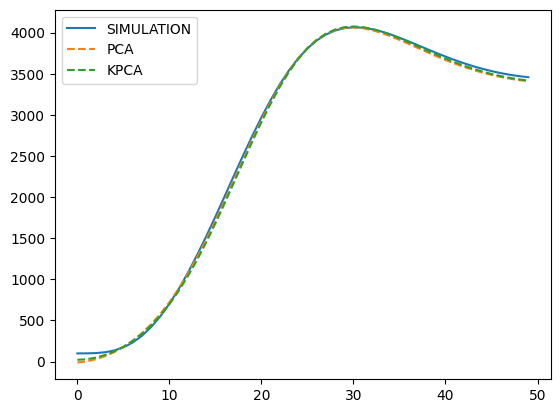

In [72]:
plt.plot(total[:], label = 'SIMULATION')
plt.plot(total_linear[:],'--', label = 'PCA')
plt.plot(total_oldroyd[:],'--', label = 'KPCA')
plt.legend()

In [57]:
total_100 = total

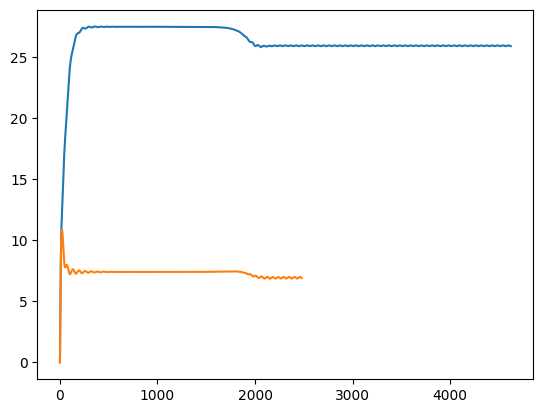

In [130]:
# plt.plot(total_001)
plt.plot(total_1)
plt.plot(total_100)

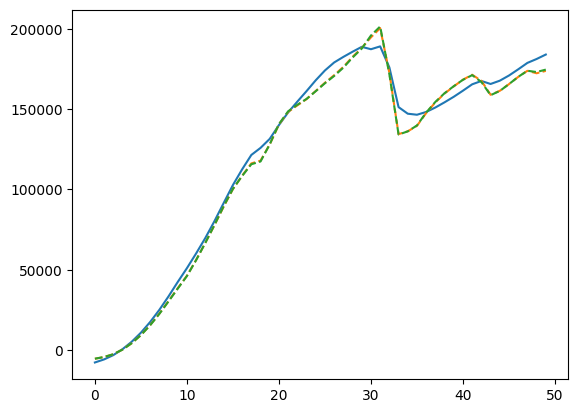

In [16]:
plt.plot(elastic)
plt.plot(elastic_linear,'--')
plt.plot(elastic_oldroyd,'--')

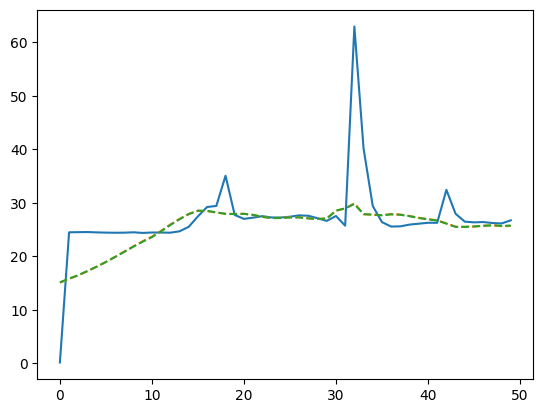

In [17]:
plt.plot(kinetic)
plt.plot(kinetic_linear,'--')
plt.plot(kinetic_oldroyd,'--')

In [74]:
modes_list = np.arange(1,11)
F_pca, H_pca, E_pca = get_reconst(Re,Wi,beta,None, X, modes_list, 'linear', 'oldroyd', 'DIV')
F_oldroyd, H_oldroyd, E_oldroyd = get_reconst(Re,Wi,beta,None, X, modes_list, 'oldroyd', 'oldroyd', 'DIV')

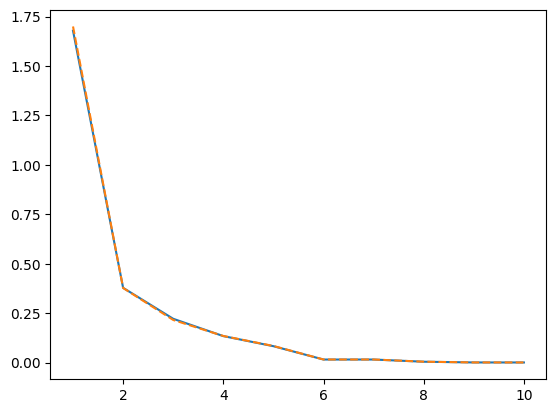

In [22]:
plt.plot(modes_list,E_pca)
plt.plot(modes_list,E_oldroyd, '--')